In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def TDT(n1,n2,n3,n4,n5,n6):
    b = n1+n3+2*n4; c = n2+n3+2*n5
    if b +c == 0:
        return 0
    else:
        return (b-c)**2/(b+c)

In [3]:
def DOLS(p,q,r,s,t,u): #direction-oriented local sensitivity
    stat = TDT(p,q,r,s,t,u); v = np.zeros(0)
    M = TDT(p,q,r,s,t,u); m = TDT(p,q,r,s,t,u)
    if p >= 1:
        v = [TDT(p-1,q+1,r,s,t,u), TDT(p-1,q,r+1,s,t,u), TDT(p-1,q,r,s+1,t,u), 
             TDT(p-1,q,r,s,t+1,u), TDT(p-1,q,r,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if q >= 1:
        v = [TDT(p+1,q-1,r,s,t,u), TDT(p,q-1,r+1,s,t,u), TDT(p,q-1,r,s+1,t,u), 
             TDT(p,q-1,r,s,t+1,u), TDT(p,q-1,r,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if r >= 1:
        v = [TDT(p+1,q,r-1,s,t,u), TDT(p,q+1,r-1,s,t,u), TDT(p,q,r-1,s+1,t,u), 
             TDT(p,q,r-1,s,t+1,u), TDT(p,q,r-1,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if s >= 1:
        v = [TDT(p+1,q,r,s-1,t,u), TDT(p,q+1,r,s-1,t,u), TDT(p,q,r+1,s-1,t,u), 
             TDT(p,q,r,s-1,t+1,u), TDT(p,q,r,s-1,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if t >= 1:
        v = [TDT(p+1,q,r,s,t-1,u), TDT(p,q+1,r,s,t-1,u), TDT(p,q,r+1,s,t-1,u), 
             TDT(p,q,r,s+1,t-1,u), TDT(p,q,r,s,t-1,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if u >= 1:
        v = [TDT(p+1,q,r,s,t,u-1), TDT(p,q+1,r,s,t,u-1), TDT(p,q,r+1,s,t,u-1), 
             TDT(p,q,r,s+1,t,u-1), TDT(p,q,r,s,t+1,u-1)]
        M = max([max(v),M])
        m = min([min(v),m])
    
    dolsp = M-stat; dolsn = stat-m
    return dolsp, dolsn

In [4]:
def DOLS_all(n):
    dolsp = np.zeros((n+1,n+1,n+1,n+1,n+1)); dolsn = np.zeros((n+1,n+1,n+1,n+1,n+1))
    for p in range(n+1):
        for q in range(n-p+1):
            for r in range(n-p-q+1):
                for s in range(n-p-q-r+1):
                    for t in range(n-p-q-r-s+1):
                        u = n-p-q-r-s-t
                        if p+2*s >= q+2*t:
                            dolsp[p][q][r][s][t], dolsn[p][q][r][s][t] = DOLS(p,q,r,s,t,u)
    for p in range(n+1):
        for q in range(n-p+1):
            for r in range(n-p-q+1):
                for s in range(n-p-q-r+1):
                    for t in range(n-p-q-r-s+1):
                        u = n-p-q-r-s-t
                        if p+2*s < q+2*t:
                            dolsp[p][q][r][s][t] = dolsp[q][p][r][t][s]
                            dolsn[p][q][r][s][t] = dolsn[q][p][r][t][s]
    return dolsp, dolsn

In [5]:
def S(n): #max(LS(x')/LS(x)) (LS(x) != 0)
    dolsp,dolsn = DOLS_all(n)
    vp = 1; vn = 1
    for p in range(n+1):
        for q in range(n-p+1):
            for r in range(n-p-q+1):
                for s in range(n-p-q-r+1):
                    for t in range(n-p-q-r-s+1):
                        u = n-p-q-r-s-t
                        if p+2*s >= q+2*t:
                            ssp = dolsp[p][q][r][s][t]; ssn = dolsn[p][q][r][s][t]
                            if p >= 1:
                                ssp = max([dolsp[p-1][q+1][r][s][t], dolsp[p-1][q][r+1][s][t], dolsp[p-1][q][r][s+1][t],
                                          dolsp[p-1][q][r][s][t+1], dolsp[p-1][q][r][s][t], ssp])
                                ssn = max([dolsn[p-1][q+1][r][s][t], dolsn[p-1][q][r+1][s][t], dolsn[p-1][q][r][s+1][t],
                                          dolsn[p-1][q][r][s][t+1], dolsn[p-1][q][r][s][t], ssn])
                            if q >= 1:
                                ssp = max([dolsp[p+1][q-1][r][s][t], dolsp[p][q-1][r+1][s][t], dolsp[p][q][r][s+1][t],
                                          dolsp[p][q-1][r][s][t+1], dolsp[p][q-1][r][s][t], ssp])
                                ssn = max([dolsn[p+1][q-1][r][s][t], dolsn[p][q-1][r+1][s][t], dolsn[p][q][r][s+1][t],
                                          dolsn[p][q-1][r][s][t+1], dolsn[p][q-1][r][s][t], ssn])
                            if r >= 1:
                                ssp = max([dolsp[p+1][q][r-1][s][t], dolsp[p][q+1][r-1][s][t], dolsp[p][q][r-1][s+1][t],
                                          dolsp[p][q][r-1][s][t+1], dolsp[p][q][r-1][s][t], ssp])
                                ssn = max([dolsn[p+1][q][r-1][s][t], dolsn[p][q+1][r-1][s][t], dolsn[p][q][r-1][s+1][t],
                                          dolsn[p][q][r-1][s][t+1], dolsn[p][q][r-1][s][t], ssn])
                            if s >= 1:
                                ssp = max([dolsp[p+1][q][r][s-1][t], dolsp[p][q+1][r][s-1][t], dolsp[p][q][r+1][s-1][t],
                                          dolsp[p][q][r][s-1][t+1], dolsp[p][q][r][s-1][t], ssp])
                                ssn = max([dolsn[p+1][q][r][s-1][t], dolsn[p][q+1][r][s-1][t], dolsn[p][q][r+1][s-1][t],
                                          dolsn[p][q][r][s-1][t+1], dolsn[p][q][r][s-1][t], ssn])
                            if t >= 1:
                                ssp = max([dolsp[p+1][q][r][s][t-1], dolsp[p][q+1][r][s][t-1], dolsp[p][q][r+1][s][t-1],
                                          dolsp[p][q][r][s+1][t-1], dolsp[p][q][r][s][t-1], ssp])
                                ssn = max([dolsn[p+1][q][r][s][t-1], dolsn[p][q+1][r][s][t-1], dolsn[p][q][r+1][s][t-1],
                                          dolsn[p][q][r][s+1][t-1], dolsn[p][q][r][s][t-1], ssn])
                            if u >= 1:
                                ssp = max([dolsp[p+1][q][r][s][t], dolsp[p][q+1][r][s][t], dolsp[p][q][r+1][s][t],
                                          dolsp[p][q][r][s+1][t], dolsp[p][q][r][s][t+1], ssp])
                                ssn = max([dolsn[p+1][q][r][s][t], dolsn[p][q+1][r][s][t], dolsn[p][q][r+1][s][t],
                                          dolsn[p][q][r][s+1][t], dolsn[p][q][r][s][t+1], ssn])
                            if dolsp[p][q][r][s][t] != 0 and dolsn[p][q][r][s][t] != 0:
                                vp = max([ssp/dolsp[p][q][r][s][t], vp])
                                vn = max([ssn/dolsn[p][q][r][s][t], vn])
    return vp,vn

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


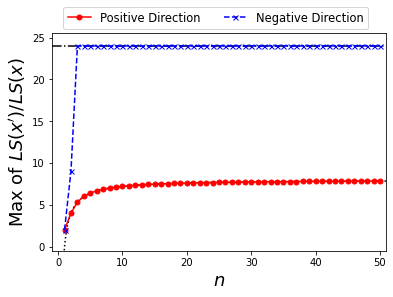

In [6]:
maxRP = np.zeros(50); maxRN = np.zeros(50); index = np.zeros(50)

for i in range(50):
    maxRP[i], maxRN[i] = S(i+1)
    index[i] = i+1

fig = plt.figure()
plt.ylim(-0.5, 25.5)
plt.xlim(-1, 51)
plt.hlines(24,-1,51,color="black", linestyle = "dashdot")
x = np.arange(0.1, 51, 0.02)
plt.plot(x,8*(x-1)/x,color="black", linestyle = "dotted")
plt.plot(index, maxRP, marker="o", markersize=5, color = "red", linestyle = "-", label = "Positive Direction")
plt.plot(index, maxRN, marker="x", markersize=5, color = "blue", linestyle = "--", label = "Negative Direction")
plt.xlabel("$n$", fontsize = 18)
plt.ylabel("Max of $LS(x')/LS(x)$", fontsize = 18)
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=11.5)
fig.savefig("goodBeta_TDT.png")
fig.savefig("figs/goodBeta_TDT.eps", bbox_inches="tight", pad_inches=0.05)